In [1]:
import os
print(os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd()) 


/home/mbortkie/repos/crl_subgoal/src/notebooks
/home/mbortkie/repos/crl_subgoal/src


In [2]:
import functools
import os

import wandb
import distrax

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs


In [3]:
EPISODE_LENGTH = 100
NUM_ENVS = 8

In [4]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

In [5]:
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))

dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

In [6]:
agent, config = restore_agent(example_batch, "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0/", 50)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_50.pkl


In [7]:
keys = random.split(random.PRNGKey(0), 8)
state, info = env.reset(keys)


In [8]:
agent.sample_actions(state.grid.reshape(state.grid.shape[0], -1), state.goal.reshape(state.goal.shape[0], -1), seed=random.PRNGKey(0))

Array([1, 2, 2, 5, 2, 0, 0, 2], dtype=int32)

In [9]:
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)


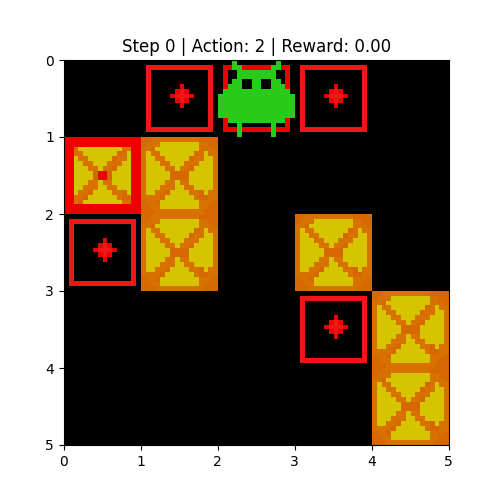

In [10]:
import IPython.display as display

grid_size = state.grid.shape[-2:]
fig, ax = plt.subplots(figsize=grid_size)

animate = functools.partial(env.animate, ax, timesteps, img_prefix=os.path.join(ROOT_DIR, 'assets'))

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

# Save as GIF
gif_path = f"/tmp/block_moving_epoch.gif"
anim.save(gif_path, writer='pillow')
plt.close()


# Visualize the GIF in the notebook
display.display(display.Image(filename=gif_path))


In [11]:
timesteps.grid.shape

(8, 100, 5, 5)

In [12]:
timesteps_tr = jax.tree_util.tree_map(lambda x: x[0], timesteps)

timesteps_tr.grid.shape

(100, 5, 5)

In [13]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps_tr.replace(),
    lambda: timesteps_tr.replace(
        grid=GridStatesEnum.remove_targets(timesteps_tr.grid),
        goal=GridStatesEnum.remove_targets(timesteps_tr.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [14]:
tr_states[0]

Array([[0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [3, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1]], dtype=int8)

In [15]:
print(f"timesteps_tr.grid.shape: {timesteps_tr.grid.shape}")
print(f"timesteps_tr.action.shape: {timesteps_tr.action.shape}")
print(f"timesteps_tr.goal.shape: {timesteps_tr.goal.shape}")

timesteps_tr.grid.shape: (100, 5, 5)
timesteps_tr.action.shape: (100,)
timesteps_tr.goal.shape: (100, 5, 5)


In [16]:
tr_actions[-20:]

Array([2, 5, 0, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [17]:
tr_states.shape

(100, 5, 5)

2025-07-24 21:10:13.941490: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


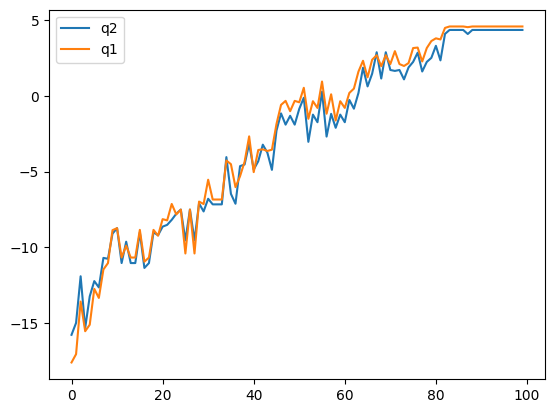

In [18]:
q1, q2 = agent.network.select('critic')(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), tr_actions.reshape(tr_actions.shape[0]))

plt.plot(jnp.log(q2), label='q2')
plt.plot(jnp.log(q1), label='q1')
plt.legend()
plt.show()

In [19]:
dist = agent.network.select('actor')(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), temperature=1)
actions = dist.sample(seed=jax.random.PRNGKey(0))


2025-07-24 21:10:15.502836: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [20]:
dist.logits.shape

(100, 6)

In [21]:
dist.probs.shape

(100, 6)

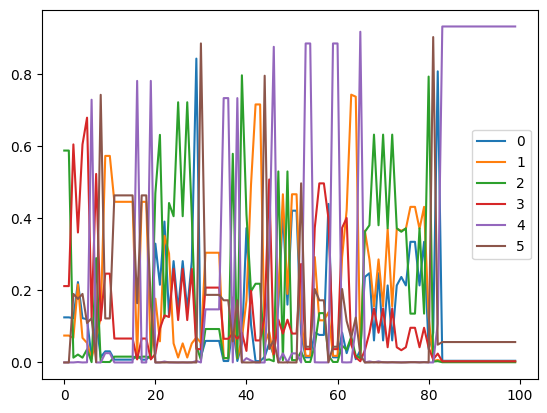

In [22]:
for i in range(dist.probs.shape[1]):
    plt.plot(dist.probs[:,i], label=f'{i}')
plt.legend()
plt.show()

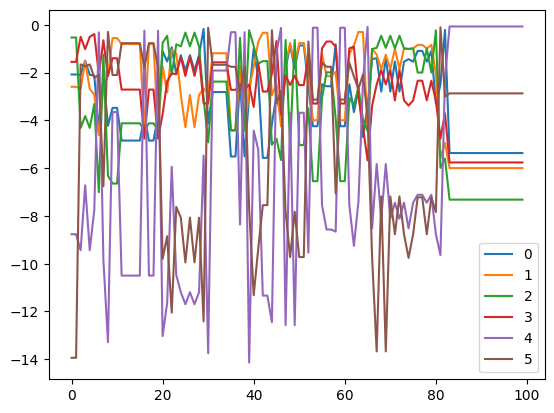

In [23]:
for i in range(dist.logits.shape[1]):
    plt.plot(dist.logits[:,i], label=f'{i}')
plt.legend()
plt.show()

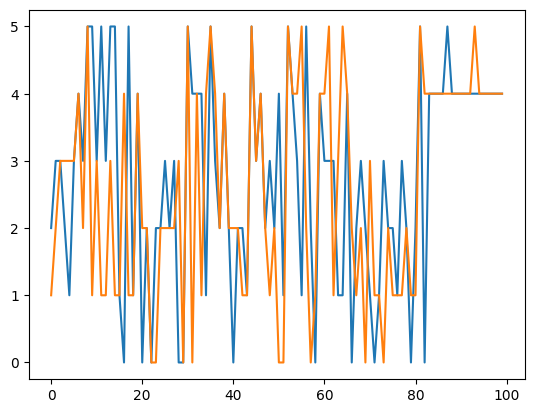

In [24]:
plt.plot(tr_actions)
plt.plot(actions)
plt.show()

# Distribution of actions based on Q values

In [25]:
def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))
all_actions = jnp.tile(jnp.arange(6), (tr_states.shape[0], 1))  # B x 6
print(f"all_actions.shape: {all_actions.shape}")
qs = jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1))(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), all_actions) # 6 x 2 x B
qs = qs.min(axis=1) # 6 x B
print(f"qs.shape: {qs.shape}")
# qs_argmax_actions = jnp.argmax(qs, axis=0) # B
qs = value_transform(qs)

all_actions.shape: (100, 6)
qs.shape: (6, 100)


In [26]:
qs = qs.transpose(1, 0)
qs.shape

(100, 6)

In [27]:
distribution_from_qs = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
distribution_from_qs_temp_0_1 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 0.1))
distribution_from_qs_temp_0_5 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 0.5))
distribution_from_qs_temp_10 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 10))

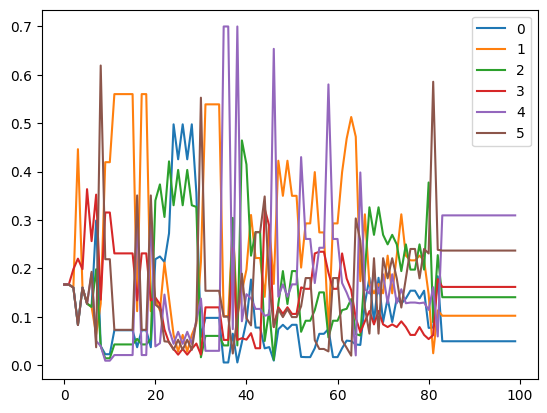

In [28]:
for i in range(distribution_from_qs.probs.shape[1]):
    plt.plot(distribution_from_qs.probs[:,i], label=f'{i}')
plt.legend()
plt.show()

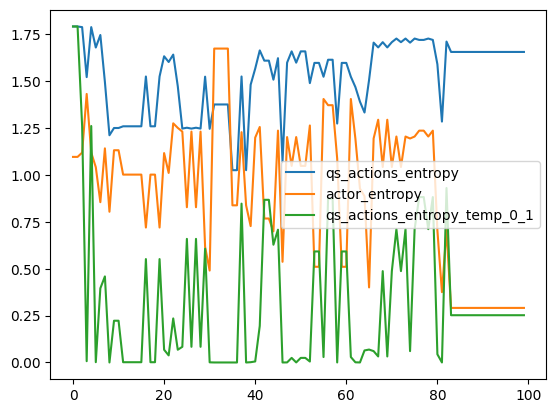

In [29]:
plt.plot(distribution_from_qs.entropy(), label='qs_actions_entropy')
plt.plot(dist.entropy(), label='actor_entropy')
# plt.plot(distribution_from_qs_temp_0_5.entropy(), label='qs_actions_entropy_temp_0_5')
plt.plot(distribution_from_qs_temp_0_1.entropy(), label='qs_actions_entropy_temp_0_1')
# plt.plot(distribution_from_qs_temp_10.entropy(), label='qs_actions_entropy_temp_10')
plt.legend()
plt.show()

### Q in time

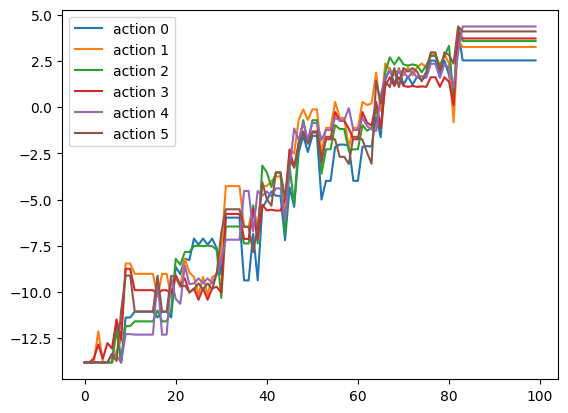

In [30]:
for i in range(qs.shape[1]):
    plt.plot(qs[:,i], label=f'action {i}')
plt.legend()
plt.show()

# Analysis of representations


In [31]:
v, phi, psi= jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1, None))(tr_states.reshape(tr_states.shape[0], -1), tr_states.reshape(tr_states.shape[0], -1), all_actions, True) # 6 x 2 x B
print(f"v.shape: {v.shape}")
print(f"phi.shape: {phi.shape}")
print(f"psi.shape: {psi.shape}")


v.shape: (6, 2, 100)
phi.shape: (6, 2, 100, 64)
psi.shape: (6, 2, 100, 64)


In [32]:
(psi[0,0,:5] == psi[1,0,:5]).all()

Array(True, dtype=bool)

In [33]:
phi = phi[:,0,:]
psi = psi[0,0,:]
phi.shape, psi.shape

((6, 100, 64), (100, 64))

phi_for_pca.shape: (100, 64)
phi_for_pca.shape: (100, 64)
phi_for_pca.shape: (100, 64)
phi_for_pca.shape: (100, 64)
phi_for_pca.shape: (100, 64)
phi_for_pca.shape: (100, 64)


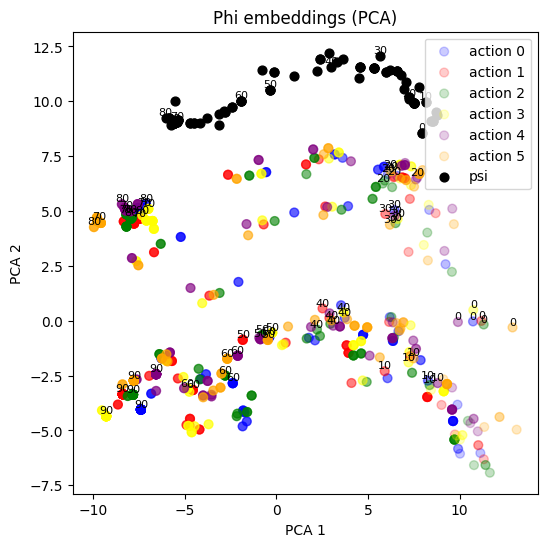

In [34]:
from sklearn.decomposition import PCA
import matplotlib as mpl
import numpy as np

# We'll flatten ensemble and batch for PCA, or just use one ensemble member

# Use base colors, but fade with timestep (alpha)
base_colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'purple',
    5: 'orange'
}
plt.figure(figsize=(6, 6))



pca = PCA(n_components=2)
phi_2d = pca.fit_transform(phi.reshape(-1, phi.shape[-1]))

for action_id in range(6):
    phi_for_pca = phi[action_id]  # shape (batch, latent_dim)
    print(f"phi_for_pca.shape: {phi_for_pca.shape}")

    # Apply PCA to reduce to 2D
    phi_2d = pca.transform(phi_for_pca)

    # Create a colormap for this action, fading from alpha=0.2 to alpha=1.0
    n_points = phi_2d.shape[0]
    base_color = mpl.colors.to_rgb(base_colors[action_id])
    alphas = np.linspace(0.2, 1.0, n_points)
    colors = [(*base_color, alpha) for alpha in alphas]

    sc = plt.scatter(phi_2d[:, 0], phi_2d[:, 1], c=colors, s=40, label=f'action {action_id}')

    # if action_id == 0:
    for i in range(0, phi_2d.shape[0], 10):
        plt.text(
            phi_2d[i, 0], phi_2d[i, 1] + 0.02,  # shift label slightly above the point
            str(i), color='black', fontsize=8, ha='center', va='bottom'
        )

psi_2d = pca.transform(psi)
plt.scatter(psi_2d[:, 0], psi_2d[:, 1], c='black', s=40, label='psi')
# Write labels (id) above every 10th point
for i in range(0, psi_2d.shape[0], 10):
    plt.text(
        psi_2d[i, 0], psi_2d[i, 1] + 0.02,  # shift label slightly above the point
        str(i), color='black', fontsize=8, ha='center', va='bottom'
    )


plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Phi embeddings (PCA)')
plt.legend()
plt.show()


# Rank

In [35]:
print(config.env)

BoxPushingConfig(grid_size=5, number_of_boxes_min=3, number_of_boxes_max=7, number_of_moving_boxes_max=5, episode_length=100, truncate_when_success=False, dense_rewards=False, level_generator='default')


In [36]:
config.env.number_of_moving_boxes_max=1
config.env.number_of_boxes_min=1
config.env.number_of_boxes_max=1
print(config.env)
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))


BoxPushingConfig(grid_size=5, number_of_boxes_min=1, number_of_boxes_max=1, number_of_moving_boxes_max=1, episode_length=100, truncate_when_success=False, dense_rewards=False, level_generator='default')


In [37]:
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)


In [38]:
timesteps.grid.shape

(8, 100, 5, 5)

In [39]:
all_actions = jnp.tile(jnp.arange(6), (timesteps.grid.shape[0]*timesteps.grid.shape[1], 1))  # B x 6
all_actions.shape

(800, 6)

In [40]:
v, phi, psi= jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1, None))(timesteps.grid.reshape(timesteps.grid.shape[0]*timesteps.grid.shape[1], -1), timesteps.grid.reshape(timesteps.grid.shape[0]*timesteps.grid.shape[1], -1), all_actions, True) # 6 x 2 x B

In [41]:
print(f"v.shape: {v.shape}")
print(f"phi.shape: {phi.shape}")
print(f"psi.shape: {psi.shape}")

v.shape: (6, 2, 800)
phi.shape: (6, 2, 800, 64)
psi.shape: (6, 2, 800, 64)


In [42]:
psi = psi[0,0,:]
psi.shape
psi.ndim

2

In [43]:

# Compute the singular values of psi (flatten to 2D if needed)
psi_2d = psi if psi.ndim == 2 else psi.reshape(psi.shape[0], -1)
s = np.linalg.svd(psi_2d, compute_uv=False)

# Effective rank: number of singular values above a threshold (e.g., 1e-5 times the largest)
threshold = 1e-5 * s[0]
effective_rank = jnp.sum(s > threshold)

print("psi.shape:", psi.shape)
print("Singular values:", s)
print("Effective rank of psi:", effective_rank)



psi.shape: (800, 64)
Singular values: [535.2558    298.1742     91.4891     82.998245   78.474754   71.36837
  62.973583   59.03676    46.564655   42.22953    36.377888   35.931698
  31.389559   28.904972   27.578262   26.943373   26.326084   25.389917
  25.050312   24.102322   22.546831   21.817034   19.73022    19.520681
  17.254442   15.944672   15.233834   14.2311735  13.62752    12.829184
  12.659111   12.04147    11.517023   10.958533   10.685381    9.753773
   9.427626    8.92593     8.286273    8.16623     7.6014547   7.040801
   6.752124    6.5837364   6.1777644   5.986       5.9272194   5.3148384
   5.253928    5.1172957   4.9874687   4.689227    4.3209653   4.0866437
   3.8766053   3.7571204   3.54691     3.3149042   3.1271684   2.9128335
   2.5910637   2.5643926   2.1259272   1.99649  ]
Effective rank of psi: 64


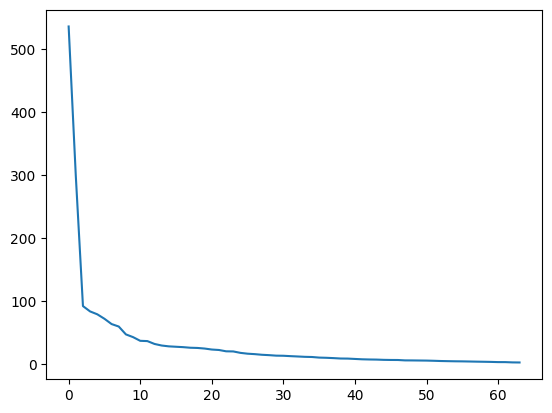

In [44]:
plt.plot(s)


--- number_of_boxes = 1 ---
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_0.pkl
ckpt 0: effective_rank_psi=44.45, effective_rank_phi=43.57
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_10.pkl
ckpt 10: effective_rank_psi=26.67, effective_rank_phi=26.14
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_20.pkl
ckpt 20: effective_rank_psi=25.74, effective_rank_phi=25.06
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_30.pkl
ckpt 30: effective_rank_psi=24.04, effective_rank_phi=23.76
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_box

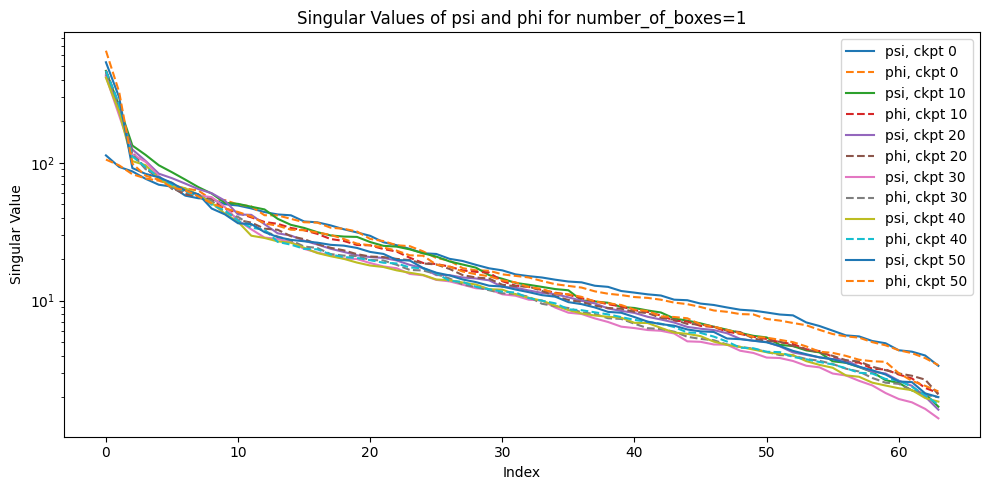


--- number_of_boxes = 3 ---
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_0.pkl
ckpt 0: effective_rank_psi=42.54, effective_rank_phi=42.26
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_10.pkl
ckpt 10: effective_rank_psi=15.36, effective_rank_phi=11.78
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_20.pkl
ckpt 20: effective_rank_psi=15.55, effective_rank_phi=12.27
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_30.pkl
ckpt 30: effective_rank_psi=15.96, effective_rank_phi=12.25
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_box

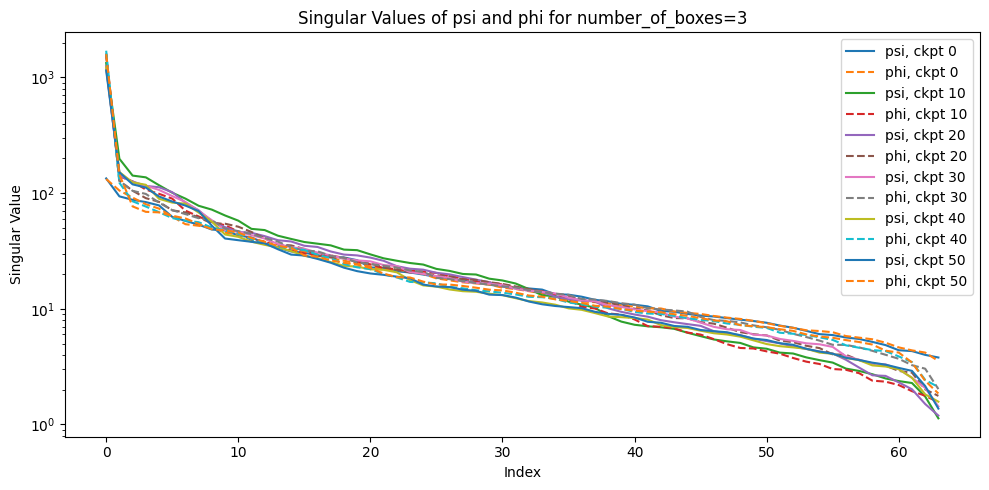


--- number_of_boxes = 5 ---
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_0.pkl
ckpt 0: effective_rank_psi=42.19, effective_rank_phi=40.16
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_10.pkl
ckpt 10: effective_rank_psi=9.71, effective_rank_phi=7.40
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_20.pkl
ckpt 20: effective_rank_psi=10.87, effective_rank_phi=7.95
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_30.pkl
ckpt 30: effective_rank_psi=10.85, effective_rank_phi=7.77
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5

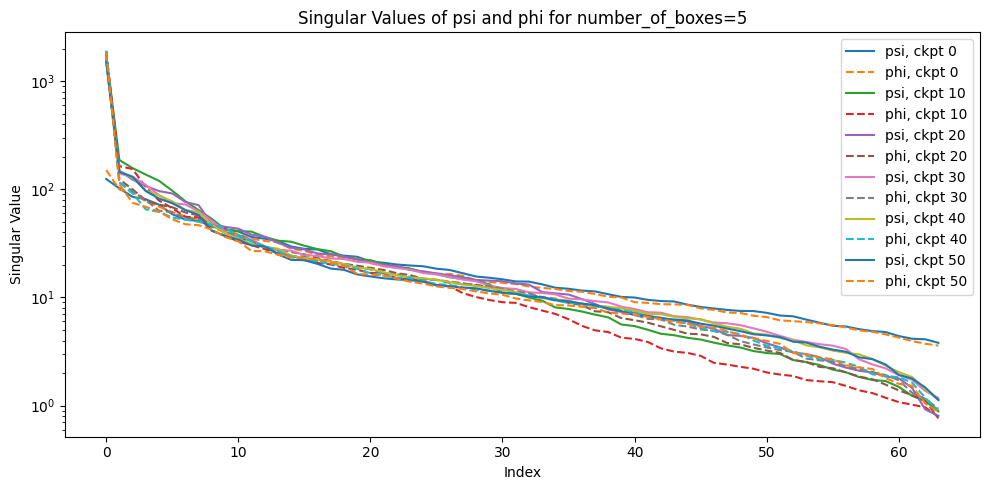


--- number_of_boxes = 7 ---
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_0.pkl
ckpt 0: effective_rank_psi=39.91, effective_rank_phi=38.75
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_10.pkl
ckpt 10: effective_rank_psi=7.60, effective_rank_phi=5.90
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_20.pkl
ckpt 20: effective_rank_psi=8.14, effective_rank_phi=6.09
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_30.pkl
ckpt 30: effective_rank_psi=7.99, effective_rank_phi=6.14
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_g

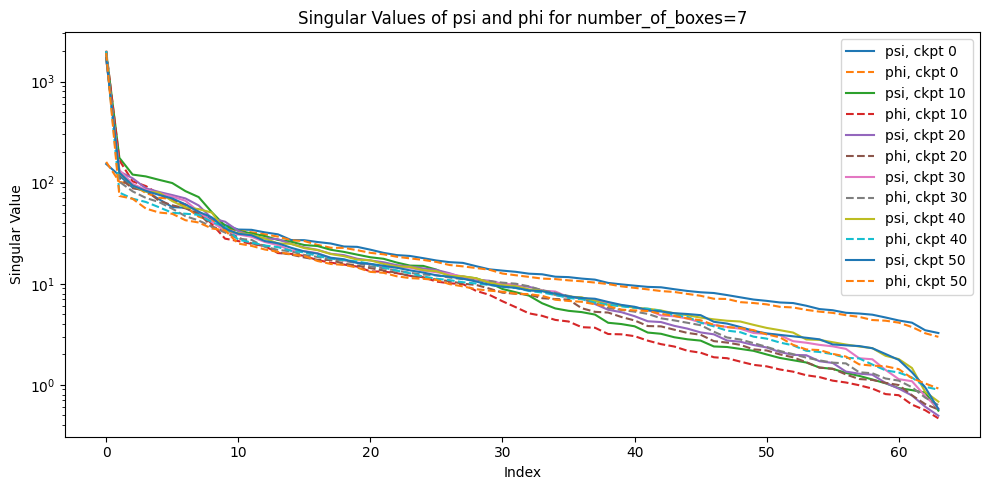

In [50]:
def compute_effective_rank(matrix):
    """Compute the effective rank of a matrix using the entropy of its singular values."""
    matrix_2d = matrix if matrix.ndim == 2 else matrix.reshape(matrix.shape[0], -1)
    s = np.linalg.svd(matrix_2d, compute_uv=False)
    rho = s / s.sum()
    H = -jnp.sum(rho * jnp.log(rho))
    effective_rank = jnp.exp(H)
    return s, effective_rank

def analyze_psi_phi_singular_values(agent, config, NUM_ENVS, EPISODE_LENGTH, number_of_boxes=1):
    # Set up environment with specified number of boxes
    for attr in ['number_of_moving_boxes_max', 'number_of_boxes_min', 'number_of_boxes_max']:
        setattr(config.env, attr, number_of_boxes)
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))

    # Collect data
    _, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
    timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)

    # Prepare actions and run critic
    B = timesteps.grid.shape[0] * timesteps.grid.shape[1]
    all_actions = jnp.tile(jnp.arange(6), (B, 1))  # B x 6
    v, phi, psi = jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1, None))(
        timesteps.grid.reshape(B, -1),
        timesteps.grid.reshape(B, -1),
        all_actions,
        True
    )  # phi and psi are 6 x 2 x B x emb_dim

    # Analyze psi
    psi_ = psi[0, 0, :]
    s_psi, effective_rank_psi = compute_effective_rank(psi_)
    # Analyze phi
    phi_ = phi[0, 0, :]
    s_phi, effective_rank_phi = compute_effective_rank(phi_)
    return s_psi, s_phi, effective_rank_psi, effective_rank_phi

def plot_singular_values_across_checkpoints(s_psi_list, s_phi_list, checkpoint_indices, number_of_boxes, title_psi="psi", title_phi="phi"):
    plt.figure(figsize=(10, 5))
    for i, (s_psi, s_phi) in enumerate(zip(s_psi_list, s_phi_list)):
        plt.plot(s_psi, label=f"psi, ckpt {checkpoint_indices[i]}")
        plt.plot(s_phi, '--', label=f"phi, ckpt {checkpoint_indices[i]}")
    plt.title(f"Singular Values of psi and phi for number_of_boxes={number_of_boxes}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

# For each number_of_boxes, plot all checkpoints on the same plot
checkpoint_indices = [0, 10, 20, 30, 40, 50]
for n_boxes in [1, 3, 5, 7]:
    s_psi_list = []
    s_phi_list = []
    eff_rank_psi_list = []
    eff_rank_phi_list = []
    print(f"\n--- number_of_boxes = {n_boxes} ---")
    for i in checkpoint_indices:
        agent, config = restore_agent(
            example_batch,
            "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0/",
            i
        )
        s_psi, s_phi, eff_rank_psi, eff_rank_phi = analyze_psi_phi_singular_values(agent, config, NUM_ENVS, EPISODE_LENGTH, number_of_boxes=n_boxes)
        s_psi_list.append(s_psi)
        s_phi_list.append(s_phi)
        eff_rank_psi_list.append(eff_rank_psi)
        eff_rank_phi_list.append(eff_rank_phi)
        print(f"ckpt {i}: effective_rank_psi={eff_rank_psi:.2f}, effective_rank_phi={eff_rank_phi:.2f}")
    plot_singular_values_across_checkpoints(s_psi_list, s_phi_list, checkpoint_indices, n_boxes)